# Example notebook for postprocessing and evaluation of CCLM output
Regridding, calculation of mean bias and plotting

## 0. Imports & settings

In [1]:
from pathlib import Path
import os
import xarray as xr
import pandas as pd

import valenspy as vp #The Valenspy package
from valenspy.inputconverter_functions import ERA5_to_CF

from yaml import safe_load


In [2]:
## Settings

# get source path
src_path = Path("../src/valenspy")

# define machine name - used for paths of (observational) datasets
machine = "hortense"

# reference dataset to compare to
ref_dataset = 'ERA5'

# define model and postprocessing direct & get path with postprocessed CCLM output
model = "CCLM"



In [3]:
# define bounds per region: for plotting and extracting data. 
bounds = {'europe':
                    {'lat_bounds': [70,35], 
                    'lon_bounds': [-15,40]}, 
        'belgium': 
                    {'lat_bounds': [52,49], 
                    'lon_bounds': [2,7]}}



## Specific settings

In [4]:
variable = "tas"

region = "europe"

experiment = "EUR11_CO_TA_GC_TSO"

period = [1995,1995]

months_to_analyse= [6,7]

## 1. Load ERA5 data

In [5]:
# start up input manager
manager = vp.InputManager(machine=machine)

# use input manager to load data, defined on settings above
ds_ref = manager.load_data(ref_dataset,variable, period=period,freq="daily",region=region, path_identifiers = ["-daily-"])




File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/daily/2m_temperature/era5-daily-europe-2m_temperature-1995.nc


## 2. Load CCLM data

This will be replaced by the CCLM input manager and convertor. 

In [ ]:
## CCLM input manager will produce the paths

with open(src_path / "ancilliary_data" / Path("dataset_PATHS.yml")) as file:
    dataset_PATHS = safe_load(file)
model_directory = dataset_PATHS[machine][model]


# get lookup file for model
with open(src_path / "ancilliary_data" / Path(model+"_lookup.yml")) as file:
    mod_LOOKUP = safe_load(file)


# get CCLM variable corresponding to the requested variable using its look-up table
mod_var = mod_LOOKUP[variable]['mod_name']

# define the path
directory = Path(model_directory + experiment +'/'+mod_var + '/')

# define the CCLM files for the corresponding variable
mod_files = list(directory.glob(mod_var+"_daymean.nc")) # Select all the netCDF files in the directory

In [ ]:
## CCLM input convertor will load the variables and convert them to CF compliant

if not mod_files:  # empty list
        print(f"{variable} not available for {experiment}")
else: 
    
    ds_mod = xr.open_mfdataset(mod_files, combine="by_coords", chunks="auto")


## 3. Do regridding

In this example CCLM output is regridded to the reference dataset grid (here ERA5)

In [ ]:
## Regridding function - transform this one into Valenspy

def remap_cdo(gridfile: str, gridname: str, files_to_regrid: list, remap_method: str):
    """
    Remaps a list of NetCDF files to a new grid using CDO (Climate Data Operators).

    This function performs regridding of the given NetCDF files to the grid defined 
    by `gridfile` using the specified remap method. It saves the regridded files in 
    a "regridded" subdirectory within the directory where the original files are located 
    and returns the combined dataset.

    Parameters:
    -----------
    gridfile : str
        Path to the NetCDF file that defines the target grid for regridding.

    gridname : str
        Name to be used in the naming of the regridded files.
    
    files_to_regrid : list
        List of paths to the NetCDF files that need to be regridded.
    
    remap_method : str
        Method to be used for regridding. This should be a valid remapping method 
        supported by CDO (e.g., "remapbil", "remapcon").

    Returns:
    --------
    xarray.Dataset
        The combined xarray Dataset containing all the regridded files.

    Notes:
    ------
    - This function uses the CDO command line tool to perform the regridding. 
      Ensure that CDO is installed and accessible from the command line.
    - If using the "remapcon" method, ensure that the grid cell bounds are provided 
      in the input files. Additional processing might be required to add these bounds.
    - The function renames longitude and latitude dimensions to "lon" and "lat" 
      respectively, if they are named differently in the regridded files.
    """
    # within the directory where the files to be regridded are stored, create a "regridded" folder to store the regridded files
    regrid_dir = os.path.dirname(files_to_regrid[0]) + "/regridded/"

    if not os.path.exists(regrid_dir):
        os.makedirs(regrid_dir)

    for file in files_to_regrid:
        regridded_file = os.path.join(regrid_dir, os.path.basename(file)[:-3] + '_' + ref_dataset + '_grid.nc')
        cdo_string = f"cdo {remap_method},{gridfile} {file} {regridded_file}"
        os.system(cdo_string)

    files_regridded_all = os.path.join(regrid_dir, '*' + '_' + gridname + '_grid.nc')
    ds = xr.open_mfdataset(files_regridded_all, combine="by_coords", chunks="auto")

    # Rename dimensions if necessary
    ds = ds.rename({"longitude": "lon", "latitude": "lat"}) if "longitude" in ds.coords or "latitude" in ds.coords else ds

    return ds


In [ ]:
# define the grid name as the reference dataset
gridname = ref_dataset

# retrieve reference dataset gridfile - for regridding 
gridfile = manager._get_file_paths(ref_dataset, variable, period=[1995, 1995], freq="daily", region=region, path_identifiers = ["-daily-"])[0]

# regrid
ds_mod = remap_cdo(gridfile, gridname,  mod_files, remap_method = "remapbil")

cdo    remapbil: Bilinear weights from curvilinear (446x434) to lonlat (289x163) grid


## 4. Calculate diagnostic and do plotting

In [ ]:
# select variable and corresponding period
da_mod = ds_mod[mod_var].sel(time=ds_mod['time'].dt.month.isin(months_to_analyse))
da_ref = ds_ref[variable].sel(time=ds_ref['time'].dt.month.isin(months_to_analyse))


lat_bounds = bounds[region]['lat_bounds']
lon_bounds = bounds[region]['lon_bounds']

da_mod = da_mod.sel(lon=slice(lon_bounds[0],lon_bounds[1]),lat=slice(lat_bounds[0], lat_bounds[1])).mean('time', keep_attrs=True)
da_ref = da_ref.sel(lon=slice(lon_bounds[0],lon_bounds[1]),lat=slice(lat_bounds[0], lat_bounds[1])).mean('time', keep_attrs=True)
da_bias = da_mod - da_ref


In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings

def plot_maps_mod_ref_bias(da_mod, mod_title, da_ref, ref_title, da_bias): 

    # Turn off all warnings
    warnings.filterwarnings('ignore')

    fig, axes = plt.subplots(1, 3, figsize=(14, 3), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()

    # find plotting min and max
    cbar_label = f"{da_ref.attrs['long_name']} ({da_ref.attrs['units']})"
    cbar_kwargs = {'label': cbar_label}


    # Define a function to add borders, coastlines to the axes
    def add_features(ax):
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.COASTLINE, linewidth = 0.5, color = 'k')
        ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]], crs=ccrs.PlateCarree())

    # plotting bounds
    vmin = float(min(da_mod.min().values, da_ref.min().values))
    vmax = float(max(da_mod.max().values, da_ref.max().values))

    # mod
    ax = axes[0]
    da_mod.plot(ax=ax, vmin=vmin, vmax=vmax, cbar_kwargs=cbar_kwargs)
    ax.set_title('')
    ax.set_title(mod_title, loc='right')
    add_features(ax)


    # ref
    ax = axes[1]
    da_ref.plot(ax=ax, vmin=vmin, vmax=vmax, cbar_kwargs=cbar_kwargs)
    ax.set_title('')
    ax.set_title(ref_title, loc='right')
    add_features(ax)


    # bias
    ax = axes[2]
    bias_bound = float(max(abs(da_bias.min().values), abs(da_bias.max().values)))
    da_bias.plot(ax=ax, cmap = 'coolwarm', vmax = bias_bound, vmin = - bias_bound, cbar_kwargs=cbar_kwargs)
    ax.set_title('')
    ax.set_title(f"{experiment} - {ref_dataset}", loc='right')
    add_features(ax)

    fig.suptitle(da_ref.attrs['long_name'], y=1);
    fig.tight_layout()
    plt.show()

    #fig.savefig(f"./plots/{region}_{experiment}_{ref_dataset}_timmean_bias.png")
    return fig


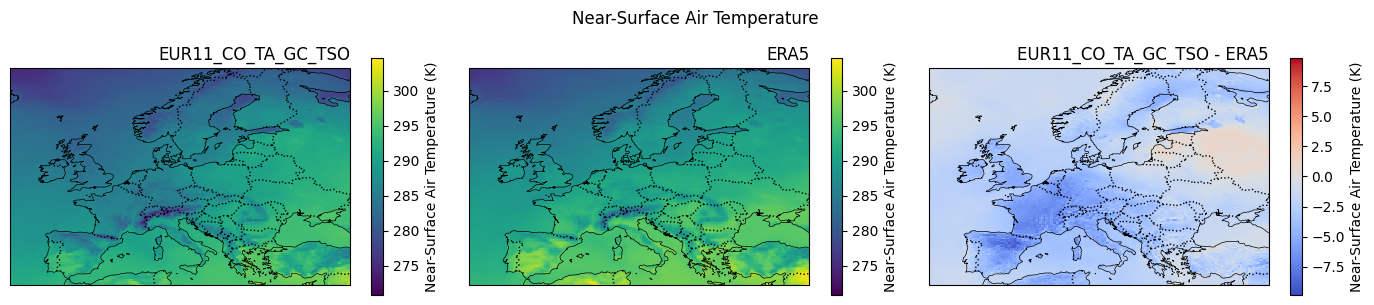

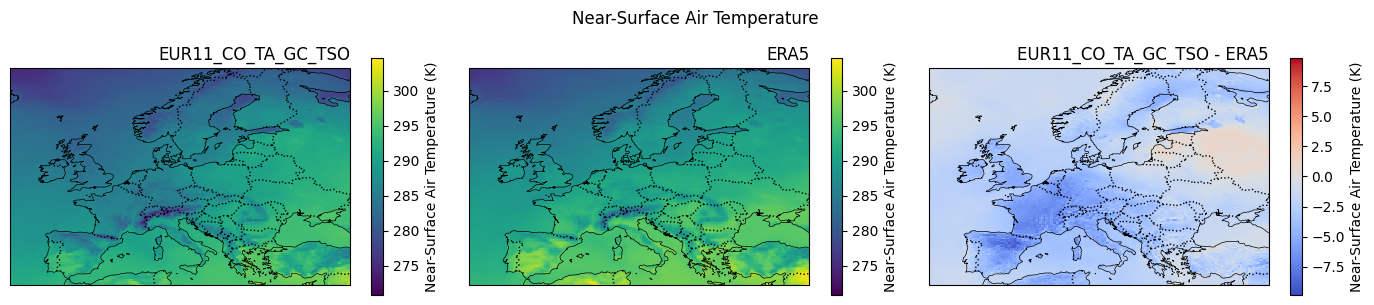

In [ ]:
plot_maps_mod_ref_bias(da_mod, experiment, da_ref, ref_dataset, da_bias)
